## Purpose  
Demonstrate how leakage can be detected using a data randomization process.  

## Process
Create fake data using linear data-generating process (DGP). Intentionally leak information through various methods and then show that this code helps detect the leakage.

In [1]:
import sys
import os
import math
import warnings

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import metrics 
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings(action='once')
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Set seed
np.random.seed(5)

In [3]:
def randomize(filepath, index_col = None, do_not_randomize = None):
    """
    Randomize column values of a file. Each column is randomized independently.
    
    Inputs:
        filepath (str): path to file to randomize; may be of type csv or txt
        index_col (str): optional name of column to use as index; will not 
            be randomized
        do_not_randomize (list): optional list of strings indicating names of 
            columns that should not be randomized
    Outputs:
        df (dataframe): dataframe representation of randomized data
        Output file will be generated, named as original file name + "_randomized"
    """
    
    # Treat csv and txt differently
    filename, file_extension = os.path.splitext(filepath)
    if file_extension == '.csv':
        sep = ","
    elif file_extension == '.txt':
        sep = "\t"
        
    # Randomize column by column
    df = pd.read_csv(filepath, sep = sep, index_col = index_col) 
    
    if do_not_randomize:
        cols = [c for c in df.columns if c not in do_not_randomize]
    else:
        cols = df.columns
        
    for col in cols:
        print('... Randomizing column ' + col)
        df[col] = np.random.permutation(df[col])
        
    # Print to new csv or txt
    new_file = filename + '_randomized' + file_extension
    df.to_csv(new_file)   
    
    return df

In [4]:
def generate_data(period, n_rows, m_columns, threshold, betas, intercept):
    
    """ 
    Generate fake data for a classification task, based on data generating process where:
    - Features are drawn iid from standard logistic distribution (location = 0, scale = 1)
    - Regression equation: y = intercept + beta_1 * x1 + .. + beta_m * xm + error
    - Error is drawn from standard normal distribution
    - Outcome is 1 if p value from logistic function exceeds threshold, 0 otherwise

    Inputs:
        period (int): time period
        n_rows (int): number of observations to generate
        m_columns (int): number of features to generate
        betas (list): list of numerical values to use as coefficients; length must equal m_columns, 
            i.e. don't include intercept
        intercept (int): constant number to use as intercept of regression equation

    Outputs:
        X (dataframe): matrix of feature variables
        y (series): outcome variable

    """
    print("Generating {} observations...".format(n_rows))

    # generate column names
    colnames = []
    for i in range(m_columns):
        colnames.append('x' + str(i + 1))

    # generate fake data
    df = pd.DataFrame(np.random.logistic(size=(n_rows, m_columns)), columns = colnames)
    df.insert(loc = 0, column = 'intercept', value = 1)
    betas = [intercept] + betas
    df['z'] = np.multiply(np.array(betas), df).sum(axis=1) + np.random.normal()
    df['pr'] = df['z'].apply(lambda x: 1/(1 + math.exp(x)))
    df['outcome'] = np.where(df['pr'] > threshold, 1, 0)
    df.index.name = 'idx'
    df['period'] = period

    return df

In [5]:
def generate_binary_pred(y_scores, k):
    """
    Generate binary predictions, where top k% of highest y_scores receive class of 1
    """
    cutoff = int(len(y_scores) * k)
    ind = np.argpartition(y_scores, -cutoff)[-cutoff:] # indices of top k probabilities
    y_pred = np.zeros(y_scores.shape[0])
    y_pred[ind] = 1
    return y_pred

In [6]:
def run_logreg(X_train, y_train, X_test, y_test, plot = True, k=0.1):
    """
    Run logistic regression on given test and training sets   
    
    Inputs
        training and test sets
        k (float): k threshold at which to make predictions and obtain precision at k
    
    Output
        dictionary containing logistic regresison model, test set, and evaluation metrics
    """
    # Record baseline accuracy, i.e. percentage of positives in training set
    baseline = np.mean(y_train)
    print("Baseline (% positives in training data): " + str(round(baseline, 3)))
    
    # Create a logistic regression object
    logreg = linear_model.LogisticRegression()

    # Train model with training set
    logreg.fit(X_train, y_train)

    # Generate probabilities with test set
    probs = logreg.predict_proba(X_test)
    
    # Make predictions at k
    y_pred = generate_binary_pred(probs[:, 1], k)
    
    # Calculate accuracy, AUC, and precision at k
    auc = metrics.roc_auc_score(y_test, probs[:, 1])
    accuracy_at_k = metrics.accuracy_score(y_test, y_pred)
    precision_at_k = metrics.precision_score(y_test, y_pred)
    recall_at_k = metrics.recall_score(y_test, y_pred)
    
    # Print metrics
    print("AUC Score: " + str(round(auc, 3)))
    print("Accuracy at {}: {}".format(k, round(accuracy_at_k, 3)))
    print("Precision at {}: {}".format(k, round(precision_at_k, 3)))
    print("Recall at {}: {}".format(k, round(recall_at_k, 3)))

    # Print confusion matrix
    print(metrics.confusion_matrix(y_test, y_pred))
    
    if plot:
        # Plot AUC curve (source: https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/)
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs[:,1])
        #print("FP rate: ", false_positive_rate, "TP rate: ", true_positive_rate)
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([-0.1,1.2])
        plt.ylim([-0.1,1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    # Create output dictionary
    output = {'model': logreg, 'baseline': baseline, 'X_test': X_test, 'y_test': y_test, 'k': k, 'y_pred': y_pred, 'probs': probs, 'scores': (auc, accuracy_at_k, precision_at_k, recall_at_k)}
    
    return output

In [7]:
def get_X_y(df):
    """
    Split data frame into X and y objects 
    """
    X = df.drop(['z', 'pr', 'outcome'], axis = 1)
    y = df['outcome']
    return X, y

def logreg_pipeline(df, k = 0.1, temporal = False, plot = True):
    """
    Put raw inputs through basic machine learning pipeline.
    
    Inputs:
        df (dataframe): Pandas dataframe representing raw input file
        k (float): k threshold at which to make predictions and obtain precision at k
        temporal (bool): Indicator for whether a temporal TimeSeriesSplit
            should be use instead of non-temporal train_test_split
        plot (bool): Indicator for whether to plot the auc curve
    Outputs:
        list of logistic regression model dictionaries; length = 1 when temporal == False
    """
    # Save results of run_logreg
    models = []
    
    # Split into train and test sets
    if temporal: # do temporal train-test split
        periods = np.sort(df.period.unique())
        splits = TimeSeriesSplit(n_splits = max(periods))
        print("\nTime series split")
        for train_index, test_index in splits.split(periods):
            print("Train periods: ", train_index, "Test periods: ", test_index)
            df_train = df[df.period.isin(train_index)]
            df_test = df[df.period.isin(test_index)]
            X_train, y_train = get_X_y(df_train)
            X_test, y_test = get_X_y(df_test)
            models.append(run_logreg(X_train, y_train, X_test, y_test, plot, k=k))

    else: # do random, non-temporal train-test split
        print("\nTrain test split -- test size = 0.33")
        X, y = get_X_y(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        models.append(run_logreg(X_train, y_train, X_test, y_test, plot, k=k))
    
    return models

In [8]:
def bootstrap_metrics(df, bootstrap_n, k, temporal = False):
    """
    Sample with replacement from original data frame a number of times. Run logistic regression pipeline on each sample
    to obtain a distribution of AUC scores for significance testing.
    
    Inputs
        df (dataframe): Pandas dataframe representing raw input file
        bootstrap_n (int): number of bootstrap samples to run
        k (float): k threshold at which to make predictions and obtain precision at k
        temporal (bool): Indicator for whether a temporal TimeSeriesSplit
            should be use instead of non-temporal train_test_split
        
    Outputs
        accuracy (array): array of accuracy at k scores of dimension bootstrap_n x num_temporal_tests
        auc_array (array): array of auc scores of dimension bootstrap_n x num_temporal_tests
        precision_k_array (array): array of precision at k scores of dimension bootstrap_n x num_temporal_tests
        recall_k_array (array): array of recall at k scores of dimension bootstrap_n x num_temporal_tests
    """
    
    all_iterations = []
    for n in range(bootstrap_n):
        sample = df.sample(df.shape[0], replace=True)
        all_iterations.append(logreg_pipeline(sample, k=k, temporal=temporal, plot=False))

    all_arr = []                         
    for i in range(4): # four scores: auc, accuracy_at_k, precision_at_k, recall_at_k
        if temporal: # each iteration contains a list of models, one for each temporal split
            scores = [[d['scores'][i] for d in iteration] for iteration in all_iterations]                  
            arr = np.array(scores)
        else: # each iteration only contains one model
            scores = [[iteration[0]['scores'][i] for iteration in all_iterations]]
            arr = np.array(scores)[:, np.newaxis]
        all_arr.append(arr)
    auc_array, accuracy_k_array, precision_k_array, recall_k_array = tuple(all_arr)                 
                              
    return auc_array, accuracy_k_array, precision_k_array, recall_k_array

In [9]:
def sig_test(scores_array, metric_name, baseline):
    """
    Use traditional significance test to check for nonrandom effects
    
    Goal: argue for a statistically significant effect, i.e. scores are different from random
    H0: avg score = baseline, i.e. random
    H1: avg score != baseline, i.e. different from random
    
    We reject null at significance level of alpha = 0.05 
    
    Inputs
        scores_array (array): array of scores from bootstrapped samples; scores can be auc, precision at k, etc
        metric_name (str): "auc" or "precision_at_k"
        baseline (float): expected score for a random classifier; ex: 0.5 for AUC, % positives for precision
            
    Outputs
        p (float): p value
    """
    print("Performing traditional two-sided t-test for ", metric_name)
    print("Null hypothesis: avg score is same as baseline")
    
    sample_mean = np.mean(scores_array)
    std_error = np.std(scores_array, ddof=1, dtype=np.float64) # unbiased estimator
    print("\nBaseline {}: {}".format(metric_name, round(baseline, 6)))
    print("Sample mean {}: {}".format(metric_name, round(sample_mean, 6)))
    print("Standard error: ", round(std_error, 6))
    
    # zero standard error: no statistical doubt that sample mean is true mean
    # rounding to 10 decimal points because of zero precision issues
    if np.around(std_error, 10) == 0.0 : 
        print("\nSomething's wrong: zero standard error!")
        if abs(sample_mean - baseline) < 0.00000000001:
            print('Fail to reject null at significance level 0.0')
            print('Inconclusive about whether avg {} is statistically different from baseline'.format(metric_name))
        else:
            print('Reject null at significance level 0.0')
            print('Avg {} is statistically different from random'.format(metric_name))
        return 1.0
    
    deg = scores_array.size - 1
    
    # Compute p-val
    t = (sample_mean - baseline) / std_error
    p = 1 - stats.t.cdf(x = abs(t), df = deg)
    print("\nt-score: ", t, "p-val: ", p)
    
    # reject null if significance level of 0.05 or lower is achieved
    if p <= 0.05:
        print('\nReject null at significance level ', round(p, 6))
        print('Avg {} is statistically different from random'.format(metric_name))
    else:
        print('\nFail to reject null at significance level ', round(p, 6))
        print('Inconclusive about whether avg {} is statistically different from baseline'.format(metric_name))
    
    return p

In [10]:
def tost(scores_array, metric_name, baseline, m):
    """
    Use two one-sided significance test (TOST) to check for negligible effect, as described here: 
        http://www.carlislerainey.com/papers/nme.pdf
    
    Goal: argue for an empirically negligible effect, i.e. scores are no different from random
    H0: avg score is in [0, baseline - m] U [baseline + m, 1], i.e. different from random
    H1: avg score is in [baseline - m, baseline + m], i.e. same as random
    
    p-value of a TOST is the maximum of the p-values of each one-sided test
    We reject null at significance level of alpha = 0.05 
    
    Inputs
        scores_array (array): array of scores from bootstrapped samples; scores can be auc, precision at k, etc
        baseline (float): expected score for a random classifier; ex: 0.5 for AUC, % positives for precision
        m (float):  We assume that the smallest substantially meaningful effect for results to be different from random
            is when score is m different from baseline (random).
            
    Outputs
        p (float): p value
    """ 
    print("Performing two one-sided t-tests (TOST) for ", metric_name)
    print("Null hypothesis: avg score is different from baseline")


    sample_mean = np.mean(scores_array)
    std_error = np.std(scores_array, ddof=1, dtype=np.float64) # unbiased estimator
    print("\nBaseline {}: {}".format(metric_name, round(baseline, 6)))
    print("Sample mean {}: {}".format(metric_name, round(sample_mean, 6)))
    print("Standard error: ", round(std_error, 6))
    
    # zero standard error: no statistical doubt that sample mean is true mean
    # rounding to 10 decimal points because of zero precision issues
    if np.around(std_error, 10) == 0.0 : 
        print("\nSomething's wrong: zero standard error!")
        if sample_mean > baseline - m and sample_mean < baseline + m:
            print('Reject null at significance level 0.0')
            print('Avg {} is statistically the same as random'.format(metric_name))
        else:
            print('Fail to reject null at significance level 0.0')
            print('Inconclusive about whether avg {} is statistically the same as random'.format(metric_name))
        return 1.0
    
    deg = scores_array.size - 1
    
    # Compute p-val for side 1: score is in [0, baseline - m], i.e. score < baseline + m
    t1 = (sample_mean - (baseline - m)) / std_error
    p1 = 1 - stats.t.cdf(x = t1, df = deg)
    print("\nt1: ", t1, "p1: ", p1)
    
    # Compute p-val for side 2: score is in [baseline + m, 1], i.e. score > baseline + m
    t2 = (sample_mean - (baseline + m)) / std_error
    p2 = stats.t.cdf(x = t2, df = deg)
    print("t2: ", t2, "p2: ", p2)
    
    # p-val is max of the two one-sided tests
    p = max(p1, p2)
    
    # reject null if significance level of 0.05 or lower is achieved
    if p <= 0.05:
        print('\nReject null at significance level ', round(p, 6))
        print('Avg {} is statistically the same as random'.format(metric_name))
    else:
        print('Fail to reject null at significance level ', round(p, 6))
        print('Inconclusive about whether avg {} is statistically the same as random'.format(metric_name))
    
    return p

## Case 1: Stable DGP 
### Non-temporal example with stable DGP; data leakage through using outcome variable as a feature

Generate data for 5 periods with constant DGP

In [11]:
frames = []
for i in range(5):
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.5, betas = [1,2,3,4,5], intercept = 1)
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...


Run original input file through pipeline.


Train test split -- test size = 0.33
Baseline (% positives in training data): 0.487
AUC Score: 0.999
Accuracy at 0.1: 0.629
Precision at 0.1: 1.0
Recall at 0.1: 0.212
[[1747    0]
 [1223  330]]


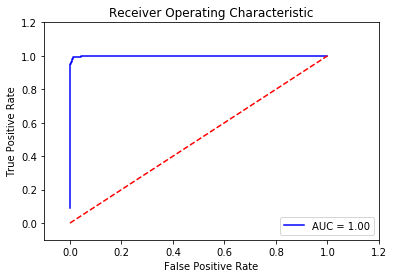

In [12]:
models = logreg_pipeline(df)

Put the input file through randomization process, then run it through the pipeline.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline (% positives in training data): 0.484
AUC Score: 0.492
Accuracy at 0.1: 0.512
Precision at 0.1: 0.448
Recall at 0.1: 0.094
[[1543  182]
 [1427  148]]


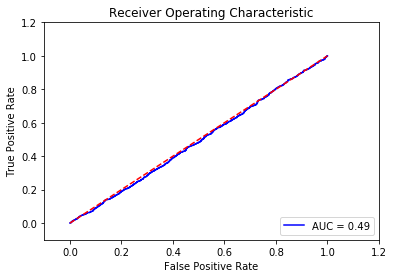

In [13]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # creates csv named fake_data_randomized.csv
models = logreg_pipeline(df_random)

Perform statistical test on bootstrapped samples. Expect to see that model performs no better than random because data has been randomized.

In [14]:
%%capture
auc_array, accuracy_k_array, precision_k_array, recall_k_array = bootstrap_metrics(df_random, 1000, k=0.1, temporal=False)

Traditional statistical test suggests no signs of scores being different from baseline, therefore no cause for concern

In [15]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

Performing traditional two-sided t-test for  auc
Null hypothesis: avg score is same as baseline

Baseline auc: 0.5
Sample mean auc: 0.508027
Standard error:  0.011054

t-score:  0.726149357656 p-val:  0.233958651674

Fail to reject null at significance level  0.233959
Inconclusive about whether avg auc is statistically different from baseline


0.23395865167438634

In [16]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

Performing traditional two-sided t-test for  precision_at_k
Null hypothesis: avg score is same as baseline

Baseline precision_at_k: 0.4819
Sample mean precision_at_k: 0.493485
Standard error:  0.030323

t-score:  0.382052453607 p-val:  0.351251856627

Fail to reject null at significance level  0.351252
Inconclusive about whether avg precision_at_k is statistically different from baseline


0.35125185662730918

Perform TOST anyways. We're able to reject null for AUC, showing that AUC is statistically the same as random. Unable to reject null for precision at k.

In [17]:
tost(auc_array, metric_name = 'auc', baseline = 0.5, m = 0.05)

Performing two one-sided t-tests (TOST) for  auc
Null hypothesis: avg score is different from baseline

Baseline auc: 0.5
Sample mean auc: 0.508027
Standard error:  0.011054

t1:  5.24951578723 p1:  9.31345589539e-08
t2:  -3.79721707192 p2:  7.75756654755e-05

Reject null at significance level  7.8e-05
Avg auc is statistically the same as random


7.7575665475527279e-05

In [18]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)

Performing two one-sided t-tests (TOST) for  precision_at_k
Null hypothesis: avg score is different from baseline

Baseline precision_at_k: 0.4819
Sample mean precision_at_k: 0.493485
Standard error:  0.030323

t1:  2.03098404778 p1:  0.0212604984246
t2:  -1.26687914056 p2:  0.102746889843
Fail to reject null at significance level  0.102747
Inconclusive about whether avg precision_at_k is statistically the same as random


0.1027468898427681

Try introducing an obvious case of data leakage by using the outcome column as a feature. Run this through the pipeline. Model performs well, as expected.


Train test split -- test size = 0.33
Baseline (% positives in training data): 0.484
AUC Score: 1.0
Accuracy at 0.1: 0.623
Precision at 0.1: 1.0
Recall at 0.1: 0.21
[[1726    0]
 [1244  330]]


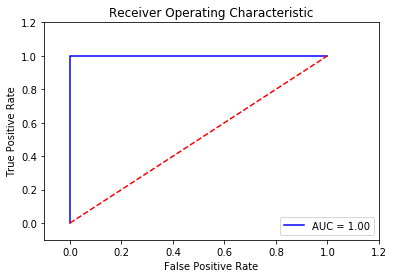

In [19]:
df['leaky_col'] = df['outcome']
models = logreg_pipeline(df)

Put the input file through randomization process. Again, introduce data leakage into the pipeline by using outcome as a feature.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline (% positives in training data): 0.477
AUC Score: 1.0
Accuracy at 0.1: 0.609
Precision at 0.1: 1.0
Recall at 0.1: 0.204
[[1680    0]
 [1290  330]]


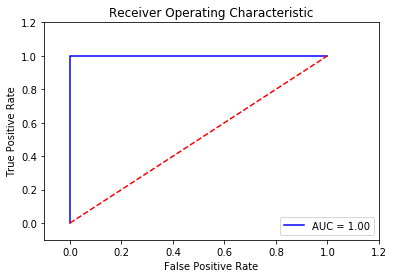

In [20]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # generates csv named "fake_data_randomized.csv"
df_random['leaky_col'] = df_random['outcome']
models = logreg_pipeline(df_random)

Perform statistical test on bootstrapped samples. Expect to see that model performs better than random, thus suggesting the existence of data leakage.

In [21]:
%%capture
auc_array, accuracy_k_array, precision_k_array, recall_k_array  = bootstrap_metrics(df_random, 1000, k=0.1, temporal=False)

Traditional statistical test suggest that scores are better than random and should cause concern

In [22]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

Performing traditional two-sided t-test for  auc
Null hypothesis: avg score is same as baseline

Baseline auc: 0.5
Sample mean auc: 1.0
Standard error:  0.0

Something's wrong: zero standard error!
Reject null at significance level 0.0
Avg auc is statistically different from random


1.0

In [23]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

Performing traditional two-sided t-test for  precision_at_k
Null hypothesis: avg score is same as baseline

Baseline precision_at_k: 0.4819
Sample mean precision_at_k: 1.0
Standard error:  0.0

Something's wrong: zero standard error!
Reject null at significance level 0.0
Avg precision_at_k is statistically different from random


1.0

Perform TOST tests to see if this effect is negligible. Tests fail to conclude that scores are the same as random; effects are not negligible!

In [24]:
tost(auc_array, metric_name = 'auc', baseline = 0.5, m = 0.05)

Performing two one-sided t-tests (TOST) for  auc
Null hypothesis: avg score is different from baseline

Baseline auc: 0.5
Sample mean auc: 1.0
Standard error:  0.0

Something's wrong: zero standard error!
Fail to reject null at significance level 0.0
Inconclusive about whether avg auc is statistically the same as random


1.0

In [25]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)

Performing two one-sided t-tests (TOST) for  precision_at_k
Null hypothesis: avg score is different from baseline

Baseline precision_at_k: 0.4819
Sample mean precision_at_k: 1.0
Standard error:  0.0

Something's wrong: zero standard error!
Fail to reject null at significance level 0.0
Inconclusive about whether avg precision_at_k is statistically the same as random


1.0

## Case 3: Regime change - intercept 
### DGP is stable over time, then the intercept suddenly changes; data leakage through non-temporal train-test split

Generate data for 5 periods with intercept change in period 2  
Dataset is in temporal order by default

In [26]:
frames = []
for i in [0,1]:
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.5, betas = [1,1,1,1,1], intercept = 1)
    frames.append(period_df)
for i in [2,3,4]:
    period_df = generate_data(period = i, n_rows = 2000, m_columns = 5, threshold = 0.5, betas = [1,2,3,4,5], intercept = -10) 
    frames.append(period_df)
df = pd.concat(frames)
df.to_csv('fake_data.csv')

Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...
Generating 2000 observations...


Run pipeline using appropriate temporal train-test split. Model does well.


Time series split
Train periods:  [0] Test periods:  [1]
Baseline (% positives in training data): 0.515
AUC Score: 1.0
Accuracy at 0.1: 0.66
Precision at 0.1: 1.0
Recall at 0.1: 0.228
[[1121    0]
 [ 679  200]]


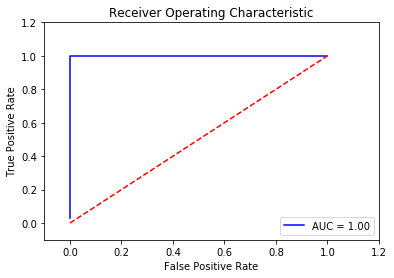

Train periods:  [0 1] Test periods:  [2]
Baseline (% positives in training data): 0.477
AUC Score: 0.955
Accuracy at 0.1: 0.35
Precision at 0.1: 1.0
Recall at 0.1: 0.133
[[ 499    0]
 [1301  200]]


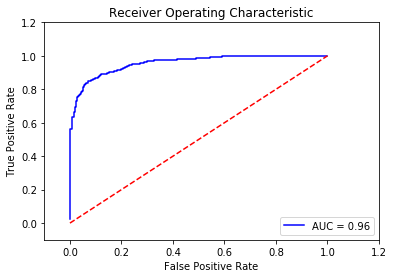

Train periods:  [0 1 2] Test periods:  [3]
Baseline (% positives in training data): 0.568
AUC Score: 0.968
Accuracy at 0.1: 0.322
Precision at 0.1: 1.0
Recall at 0.1: 0.129
[[ 445    0]
 [1355  200]]


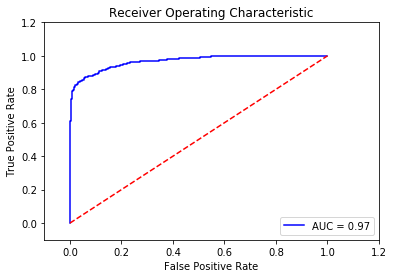

Train periods:  [0 1 2 3] Test periods:  [4]
Baseline (% positives in training data): 0.621
AUC Score: 0.98
Accuracy at 0.1: 0.343
Precision at 0.1: 1.0
Recall at 0.1: 0.132
[[ 486    0]
 [1314  200]]


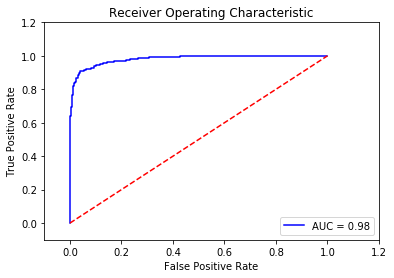

In [27]:
models = logreg_pipeline(df, temporal=True)

Put input file through randomization process, then run it through the pipeline.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Time series split
Train periods:  [0] Test periods:  [1]
Baseline (% positives in training data): 0.515
AUC Score: 0.516
Accuracy at 0.1: 0.55
Precision at 0.1: 0.45
Recall at 0.1: 0.102
[[1011  110]
 [ 789   90]]


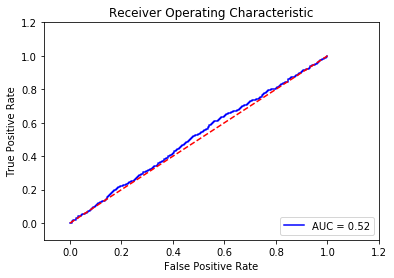

Train periods:  [0 1] Test periods:  [2]
Baseline (% positives in training data): 0.477
AUC Score: 0.481
Accuracy at 0.1: 0.298
Precision at 0.1: 0.74
Recall at 0.1: 0.099
[[ 447   52]
 [1353  148]]


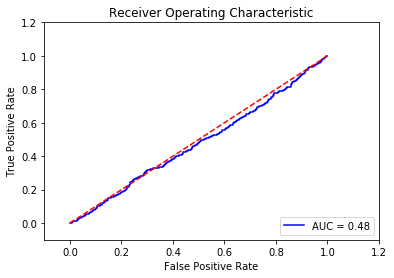

Train periods:  [0 1 2] Test periods:  [3]
Baseline (% positives in training data): 0.568
AUC Score: 0.515
Accuracy at 0.1: 0.276
Precision at 0.1: 0.765
Recall at 0.1: 0.098
[[ 398   47]
 [1402  153]]


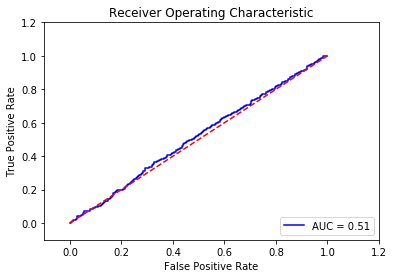

Train periods:  [0 1 2 3] Test periods:  [4]
Baseline (% positives in training data): 0.621
AUC Score: 0.496
Accuracy at 0.1: 0.293
Precision at 0.1: 0.75
Recall at 0.1: 0.099
[[ 436   50]
 [1364  150]]


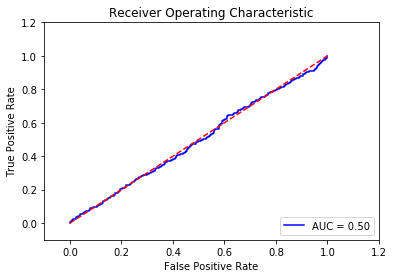

In [28]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # creates csv named fake_data_randomized.csv
models = logreg_pipeline(df_random, temporal = True)

Perform statistical test on bootstrapped samples. Expect to see that model performs no better than random because data has been randomized

In [29]:
%%capture
auc_array, accuracy_k_array, precision_k_array, recall_k_array = bootstrap_metrics(df_random, 1000, k=0.1, temporal=True)

Traditional statistical test suggests no signs of scores being different from baseline, therefore no cause for concern

In [30]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

Performing traditional two-sided t-test for  auc
Null hypothesis: avg score is same as baseline

Baseline auc: 0.5
Sample mean auc: 0.499263
Standard error:  0.020558

t-score:  -0.0358455674288 p-val:  0.485703643959

Fail to reject null at significance level  0.485704
Inconclusive about whether avg auc is statistically different from baseline


0.48570364395947518

In [31]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

Performing traditional two-sided t-test for  precision_at_k
Null hypothesis: avg score is same as baseline

Baseline precision_at_k: 0.6479
Sample mean precision_at_k: 0.685294
Standard error:  0.139109

t-score:  0.268814251545 p-val:  0.394043246266

Fail to reject null at significance level  0.394043
Inconclusive about whether avg precision_at_k is statistically different from baseline


0.39404324626569354

Perform TOST anyways. We're able to reject null for AUC, showing that AUC is statistically the same as random. Unable to reject null for precision at k.

In [32]:
tost(auc_array, metric_name = 'auc', baseline = 0.5, m = 0.05)

Performing two one-sided t-tests (TOST) for  auc
Null hypothesis: avg score is different from baseline

Baseline auc: 0.5
Sample mean auc: 0.499263
Standard error:  0.020558

t1:  2.39626211306 p1:  0.0083044531853
t2:  -2.46795324792 p2:  0.00681518002581

Reject null at significance level  0.008304
Avg auc is statistically the same as random


0.0083044531853048165

In [33]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)

Performing two one-sided t-tests (TOST) for  precision_at_k
Null hypothesis: avg score is different from baseline

Baseline precision_at_k: 0.6479
Sample mean precision_at_k: 0.685294
Standard error:  0.139109

t1:  0.628245608006 p1:  0.264939466875
t2:  -0.0906171049156 p2:  0.4639006892
Fail to reject null at significance level  0.463901
Inconclusive about whether avg precision_at_k is statistically the same as random


0.46390068919981325

Now, introduce data leakage by using non-temporal train-test split. Run this through the pipeline. Model performs well, as expected.


Train test split -- test size = 0.33
Baseline (% positives in training data): 0.654
AUC Score: 0.974
Accuracy at 0.1: 0.465
Precision at 0.1: 1.0
Recall at 0.1: 0.158
[[1206    0]
 [1764  330]]


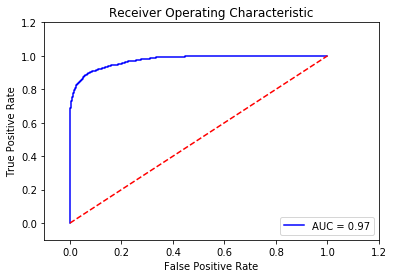

In [34]:
models = logreg_pipeline(df)

Observe model performance in each period of the test data.

In [35]:
model = models[0] # list only contains one dictionary because we ran a non-temporal pipeline

periods = np.sort(df.period.unique())

test_df = model['X_test']
test_df['y_test'] = model['y_test']
test_df['y_pred'] = model['y_pred']
test_df['probs'] = model['probs'][:, 1]

for i in periods:
    print("\nWhen test period is {}...".format(i))
    df_i = test_df[test_df.period == i]
    acc = metrics.accuracy_score(df_i.y_test, df_i.y_pred)
    auc = metrics.roc_auc_score(df_i.y_test, df_i.probs)
    prec = metrics.precision_score(df_i.y_test, df_i.y_pred)
    print("Accuracy: {}".format(round(acc,5)))
    print("AUC: {}".format(round(auc,5)))
    print("Precision at k = 0.1: {}".format(round(prec, 5)))


When test period is 0...
Accuracy: 0.52889
AUC: 0.97691
Precision at k = 0.1: 1.0

When test period is 1...
Accuracy: 0.66029
AUC: 0.98577
Precision at k = 0.1: 1.0

When test period is 2...
Accuracy: 0.33383
AUC: 0.98649
Precision at k = 0.1: 1.0

When test period is 3...
Accuracy: 0.36294
AUC: 0.98561
Precision at k = 0.1: 1.0

When test period is 4...
Accuracy: 0.43366
AUC: 0.9894
Precision at k = 0.1: 1.0


Put the input file through randomization process, randomizing all columns except period and outcome. Again, introduce data leakage into the pipeline by using non-temporal train-test split.

... Randomizing column intercept
... Randomizing column x1
... Randomizing column x2
... Randomizing column x3
... Randomizing column x4
... Randomizing column x5
... Randomizing column z
... Randomizing column pr

Train test split -- test size = 0.33
Baseline (% positives in training data): 0.646
AUC Score: 0.644
Accuracy at 0.1: 0.399
Precision at 0.1: 0.755
Recall at 0.1: 0.116
[[1068   81]
 [1902  249]]


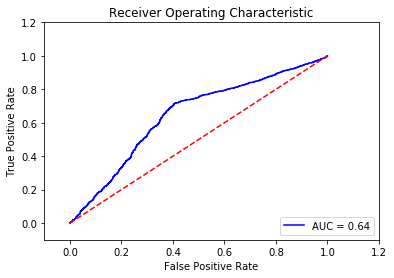

In [36]:
df_random = randomize('fake_data.csv', 'idx', ['period', 'outcome']) # generates csv named "fake_data_randomized.csv"
models = logreg_pipeline(df_random)

Observe model performance in each period of the test data.

Note: Accuracy is higher in later periods when the data generating process changes, because the baseline % of positives has decreased so it's easier to get higher accuracy figures.  

In [37]:
model = models[0] # list only contains one dictionary because we ran a non-temporal pipeline

periods = np.sort(df.period.unique())

test_df = model['X_test']
test_df['y_test'] = model['y_test']
test_df['y_pred'] = model['y_pred']
test_df['probs'] = model['probs'][:, 1]

for i in periods:
    print("\nWhen test period is {}....".format(i))
    df_i = test_df[test_df.period == i]
    acc = metrics.accuracy_score(df_i.y_test, df_i.y_pred)
    auc = metrics.roc_auc_score(df_i.y_test, df_i.probs)
    prec = metrics.precision_score(df_i.y_test, df_i.y_pred)
    print("Accuracy: {}".format(round(acc, 5)))
    print("AUC: {}".format(round(auc,5)))
    print("Precision at k = 0.1: {}".format(round(prec, 5)))
    


When test period is 0....
Accuracy: 0.49621
AUC: 0.47793
Precision at k = 0.1: 0.0

When test period is 1....
Accuracy: 0.56101
AUC: 0.48907
Precision at k = 0.1: 0.0

When test period is 2....
Accuracy: 0.23585
AUC: 0.49539
Precision at k = 0.1: 0.0

When test period is 3....
Accuracy: 0.2099
AUC: 0.48994
Precision at k = 0.1: 0.0

When test period is 4....
Accuracy: 0.48939
AUC: 0.50365
Precision at k = 0.1: 0.75455


C:\Users\JoanWang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Perform statistical test to confirm that model performs better than random, thus suggesting data leakage. Again, using non-temporal split as source of data leakage.

In [38]:
%%capture
auc_array, accuracy_k_array, precision_k_array, recall_k_array = bootstrap_metrics(df_random, 1000, k=0.1, temporal=False)

Traditional statistical test suggest that scores are better than random and should cause concern

In [39]:
sig_test(auc_array, metric_name = 'auc', baseline = 0.5)

Performing traditional two-sided t-test for  auc
Null hypothesis: avg score is same as baseline

Baseline auc: 0.5
Sample mean auc: 0.644413
Standard error:  0.010206

t-score:  14.1499349557 p-val:  0.0

Reject null at significance level  0.0
Avg auc is statistically different from random


0.0

In [40]:
sig_test(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome))

Performing traditional two-sided t-test for  precision_at_k
Null hypothesis: avg score is same as baseline

Baseline precision_at_k: 0.6479
Sample mean precision_at_k: 0.759079
Standard error:  0.025364

t-score:  4.38335734269 p-val:  6.46140876981e-06

Reject null at significance level  6e-06
Avg precision_at_k is statistically different from random


6.4614087698089406e-06

Perform TOST tests to see if this effect is negligible. Tests fail to conclude that scores are the same as random; effects are not negligible!

In [41]:
tost(auc_array, metric_name = 'auc',baseline = 0.5, m = 0.05)

Performing two one-sided t-tests (TOST) for  auc
Null hypothesis: avg score is different from baseline

Baseline auc: 0.5
Sample mean auc: 0.644413
Standard error:  0.010206

t1:  19.0490518028 p1:  0.0
t2:  9.25081810865 p2:  1.0
Fail to reject null at significance level  1.0
Inconclusive about whether avg auc is statistically the same as random


1.0

In [42]:
tost(precision_k_array, metric_name = 'precision_at_k', baseline = np.mean(df_random.outcome), m = 0.05)

Performing two one-sided t-tests (TOST) for  precision_at_k
Null hypothesis: avg score is different from baseline

Baseline precision_at_k: 0.6479
Sample mean precision_at_k: 0.759079
Standard error:  0.025364

t1:  6.35466743984 p1:  1.58477786449e-10
t2:  2.41204724554 p2:  0.991978681196
Fail to reject null at significance level  0.991979
Inconclusive about whether avg precision_at_k is statistically the same as random


0.99197868119606181